# Network Optimization


In [ ]:
# Import some libraries we will use
from torchvision import transforms as T
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import numpy as np
import sklearn

### Data Augmentation
To image, typically we can add noise (also *called* jitter) or transform the localizaiton to do data augmentation

To sound, typically we can add noise, like gumbel noise, etc

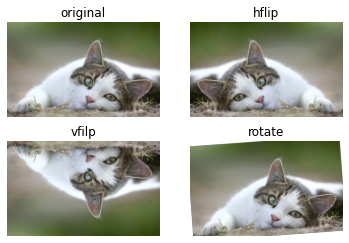

In [ ]:
# Image Data Augmentation
original_image = Image.open('/content/cat.png')
horizontal_flip = T.RandomHorizontalFlip(p=1.0)
veritical_flip = T.RandomVerticalFlip(p=1.0)
rotate = T.RandomRotation(degrees=45)

horizontal_flip_image = horizontal_flip(original_image)
veritical_flip_image = veritical_flip(original_image)
rotate_image = rotate(original_image)

images = [original_image, horizontal_flip_image, \
      veritical_flip_image, rotate_image]
titles = ['original', 'hflip', 'vfilp', 'rotate']
# show the augmented images
plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(images[i])
  plt.title(titles[i])
  plt.axis('off')
plt.show()


<function matplotlib.pyplot.show>

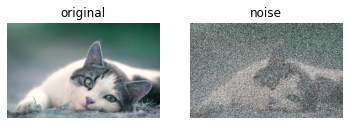

In [ ]:
# Gaussian Noise
class AddGaussianNoise(object):
  def __init__(self, mean=0, var=1.0, amplitude=1.0):
      self.mean = mean
      self.var = var
      self.amplitude = amplitude

  def __call__(self, img):
      img = np.array(img/255, dtype=float)
      h, w, c = img.shape
      N = self.amplitude * np.random.normal(loc=self.mean, scale=self.var, size=(h, w, 1))
      N = np.repeat(N, c, axis=2)
      img = N + img
      img[img > 1.0] = 1.0
      img[img < 0.0] = 0.0
      return img

# re-read image
original_image = cv2.imread('/content/cat.png')
addNoise = AddGaussianNoise()
noise_image = addNoise(original_image)

# show image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(noise_image)
plt.title('noise')
plt.axis('off')
plt.show

### Rescale Data

#### Normalization
centering: \\[ x_{normalized} = x - x_{mean} \\]


auto scaling:  \\[ x_{normalized} = (x - x_{mean})/s \\]

min-max scaling: \\[ x_{normalized} = (x - x_{min})/ (x_{max} - x_{min}) \\]

range scaling: \\[ x_{normalized} = (x - x_{mean})/ (x_{max} - x_{min}) \\]

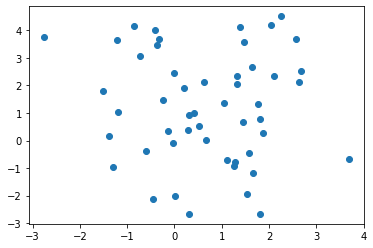

In [ ]:
# create ranodm points
x = np.random.randn(50, 2)
x[:,0] = x[:,0] * 1.2 + 0.8
x[:,1] = x[:,1] * 2 + 1.2
plt.scatter(x[:,0], x[:,1])
plt.show()

In [ ]:
def plot(x, x_new):
  plt.scatter(x[:,0], x[:,1])
  plt.scatter(x_new[:,0], x_new[:,1], color='r')
  ax = plt.gca()
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.spines['bottom'].set_position(('data', 0))
  ax.spines['left'].set_position(('data', 0))
  plt.show()

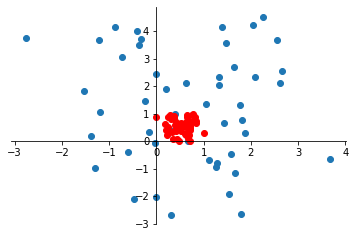

In [ ]:
def min_max_scale(x):
  """
  input [x]: size(n, 2)
  return [x_normalized]: size(n, 2)
  """
  x_min, x_max = np.min(x, axis=0), np.max(x, axis=0)
  x_normalized = np.zeros_like(x)
  x_normalized[:,0] = (x[:,0] - x_min[0]) / (x_max[0] - x_min[0])
  x_normalized[:,1] = (x[:,1] - x_min[1]) / (x_max[1] - x_min[1])
  return x_normalized
x_normalized = min_max_scale(x)
plot(x, x_normalized)

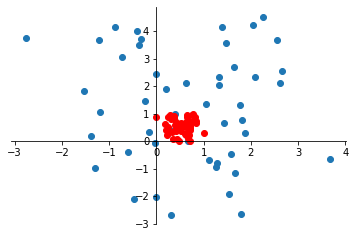

In [ ]:
# sklearn also has build-in function to do normalization
from sklearn.preprocessing import MinMaxScaler
x_normalized_sklearn = MinMaxScaler().fit_transform(x)
plot(x, x_normalized_sklearn)

#### Standardization
Make the mean of observed values is 0 and the standard deviation is 1: 
\\[ x_{standardized} = \frac{x-μ}{σ} \\]

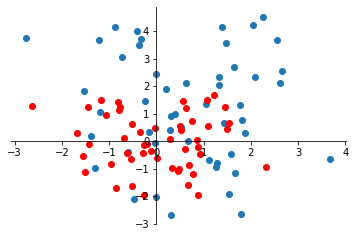

In [ ]:
def standardize(x):
  """
  input [x]: size(n, 2)
  return [x_standardized]: size(n, 2)
  """
  x_mean, x_std = np.mean(x, axis=0), np.std(x, axis=0)
  x_standardized = np.zeros_like(x)
  x_standardized[:,0] = (x[:,0] - x_mean[0]) / x_std[0]
  x_standardized[:,1] = (x[:,1] - x_mean[1]) / x_std[1]
  return x_standardized
x_standardized = standardize(x)
plot(x, x_standardized)

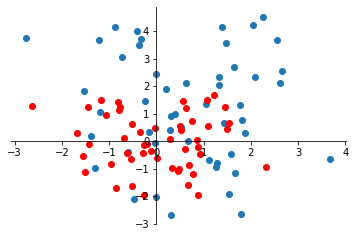

In [ ]:
# sklearn also has build-in function to do standardization
from sklearn.preprocessing import StandardScaler
x_standardized_sklearn = StandardScaler().fit_transform(x)
plot(x, x_standardized_sklearn)

### Learning rate scheduler
More detail please refer to https://pytorch.org/docs/stable/optim.html


In [ ]:
# StepLR: Decays the learning rate of each parameter group by gamma every step_size epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()

# MultiStepLR: Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving. 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='min')
for epoch in range(10):
    train(...)
    val_loss = validate(...)
    # Note that step should be called after validate()
    # ATTENTION: if we want the metrics to be large(like accuarcy), we should set mode='max'
    scheduler.step(val_loss)

In [ ]:
# track your current learning rate
cur_lr = scheduler.optimizer.state_dict()['param_groups'][0]['lr']

### Weight Initialization
Why zero or constant initializaiton doesn't work?

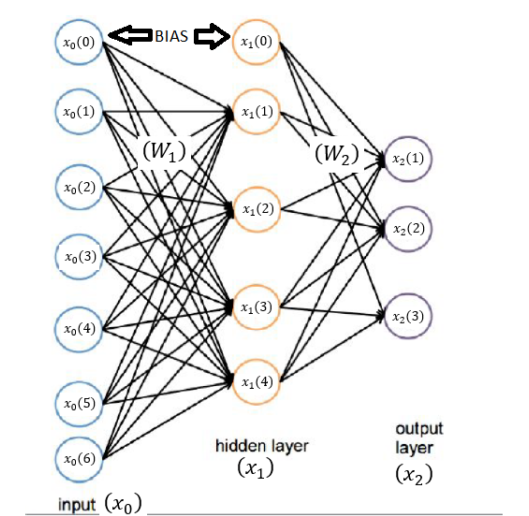

* Output:  $$ x_2=softmax(a_2)=softmax(W_2 * x_1 + b_2) $$
* Cross Entropy Loss: $$ L=crossentropy(x_2,t)=-t^T * log(x_2) $$

where x_2 is our network output and t represents ground truth, both 3 x 1 vector


In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    res = np.zeros(x.shape)
    sum = np.sum(np.exp(x))
    for i in range(x.shape[0]):
        res[i] = np.exp(x[i]) / sum
    return res

def sigmoid_deriv(a):
    return sigmoid(a) * (1 - sigmoid(a))

In [ ]:
def nerual_net(W1, W2, x0, t):
  # Forward
  # first layer
  a1 = W1 @ x0
  x1 = sigmoid(a1)
  # second layer
  a2 = W2 @ x1
  x2 = softmax(a2)

  # Back
  # derivative 
  dL_da2 = x2 - t
  dL_dW2 = dL_da2.reshape((-1, 1)) @ x1.reshape((1, -1))
  print('dL/dW2:\n', dL_dW2)

  dL_dx1 = dL_da2 @ W2  # [1,3] @ [3, 4] = [1, 4]
  dL_da1 = dL_dx1 * sigmoid_deriv(a1)
  dL_dW1 = dL_da1.reshape((-1, 1)) @ x0.reshape((1, -1))
  print('dL/dW1:\n', dL_dW1)

In [ ]:
np.set_printoptions(precision=4)

# zero initialization for weights
W1 = np.zeros((4, 6))
W2 = np.zeros((3, 4))
# input
x0 = np.array([1, 1, 0, 0, 1, 1])
# target
t = np.array([0, 1, 0])
# zero initialization
nerual_net(W1, W2, x0, t)

dL/dW2:
 [[ 0.1667  0.1667  0.1667  0.1667]
 [-0.3333 -0.3333 -0.3333 -0.3333]
 [ 0.1667  0.1667  0.1667  0.1667]]
dL/dW1:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
# constant initialization
W1 = np.ones((4, 6))
W2 = np.ones((3, 4))
nerual_net(W1, W2, x0, t)

dL/dW2:
 [[ 0.3273  0.3273  0.3273  0.3273]
 [-0.6547 -0.6547 -0.6547 -0.6547]
 [ 0.3273  0.3273  0.3273  0.3273]]
dL/dW1:
 [[-1.961e-18 -1.961e-18  0.000e+00  0.000e+00 -1.961e-18 -1.961e-18]
 [-1.961e-18 -1.961e-18  0.000e+00  0.000e+00 -1.961e-18 -1.961e-18]
 [-1.961e-18 -1.961e-18  0.000e+00  0.000e+00 -1.961e-18 -1.961e-18]
 [-1.961e-18 -1.961e-18  0.000e+00  0.000e+00 -1.961e-18 -1.961e-18]]


#### Kaiming Initialization (refer to [paper](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf))
##### Short Proof for Kaiming Initialization 

<b>Forward Pass</b>

$y_{l} = W_{l} x_{l} + b_{l}$

$x_{l+1} = Relu(y_{l})$

<b>Assumptions:</b><br>

1. $W_{l}$ is $n_{l+1} \times n_{l}$ matrix with all it's elements being iid and each distribution symmetric around the mean with $E[W_{l}] = 0$
1. $x_{l}$ is $n_{l} \times 1$ vector with all elements being iid
1. $x_{l}$ and $W_{l}$ are mutually independent (element-wise)

$Var[y_{_,l}] = n_{l} Var[w_{_,l} x_{_,l} ]$<br>
$Var[y_{_,l}] = n_{l} Var[w_{_,l}] E[x_{_,l}^2]$<br>
$Var[y_{_,l}] = \frac{1}{2} n_{l} Var[w_{_,l}] Var[y_{_,l-1}]$<br>

And behold....<br>
$Var[y_{_,L}] = Var[y_{_,1}] \prod_{i}\frac{1}{2} n_{i} Var[w_{_,i}] $

Kaiming's idea:<br>
Initialize the weights such that $\frac{1}{2}n_{i} Var[w_{_,i}] = 1$
Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i}}}$

<b>Backward Pass</b>

$\Delta x_{l} = W_{l}^T \Delta y_{l}$

$\Delta y_{l} = Relu^{'}(y_{l}) \Delta x_{l+1}$ 

<b>Assumptions:</b><br>

1. $\Delta y_{l}$ is $n_{l+1} \times 1$ vector with all elements being iid
1. $\Delta y_{l}$ and $W_{l}$ are mutually independent (element-wise)
1. $\Delta x_{l+1}$ and $Relu^{'}(y_{l})$ are mutually independent

$Var[\Delta x_{_,l}] = n_{l+1} Var[w_{_,l}^T \Delta y_{_,l}]$<br>
$Var[\Delta x_{_,l}] = n_{l+1} Var[w_{_,l}^T] Var[\Delta y_{_,l}]$<br>
$Var[\Delta x_{_,l}] = \frac{1}{2} n_{l+1} Var[w_{_,l}^T] Var[\Delta x_{_,l+1}]$<br>

Finally: <br>
$Var[\Delta x_{_,2}] = Var[\Delta x_{_,L+1}] \prod_{i=2}^L\frac{1}{2} n_{i+1} Var[w_{_,i}^T]$

Kaiming's idea:<br>
Initialize the weights such that $\frac{1}{2}n_{i+1} Var[w_{i}^T] = 1$<br>
Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}}}$

<b>Kaiming's Initialization</b>
Use either of the forward-based initialization or the backward-based initialization. The difference isn't much!

In [ ]:
# kaiming initialization in pytorch (refer to https://pytorch.org/docs/stable/nn.init.html)

# unitform distribution 
# value sampled from u~(-bound, bound), where bound = 3 * gain / sqrt(fan_mode)
w = torch.empty(2, 3)
torch.nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')
print(w)

# normal distribution 
# value sampled from N~(0, std^2), where std = gain / sqrt(fan_mode)
w = torch.empty(2, 3)
torch.nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')
print(w)

# Choosing 'fan_in' preserves the magnitude of the variance of the weights in the forward pass. Choosing 'fan_out' preserves the magnitudes in the backwards pass.

tensor([[-0.0394, -0.1105, -0.8760],
        [ 1.2181,  0.4761,  0.3609]])
tensor([[-0.9546, -0.2843, -1.3020],
        [-0.4044,  0.0542,  0.0935]])


#### Xavier's Initialization
**Similar** to Kaiming but did not consider the Relu activation and by default assumed a linear activation. Therefore the factor $\frac{1}{2}$ that we see in the Kaiming's initialization is not present in Xavier. He takes a harmonic mean of the two results for initialization.

Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}+n_{i}}}$

In [ ]:
# Xavier's initialization in pytorch (refer to https://pytorch.org/docs/stable/nn.init.html)

# unitform distribution 
# value sampled from u~(-a, a), where a =  sqrt(6 / (fan_in + fan_out))
w = torch.empty(2, 3)
torch.nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
print(w)

# normal distribution 
# value sampled from N~(0, std^2), where std = gain / sqrt(fan_mode)
w = torch.empty(2, 3)
torch.nn.init.xavier_normal_(w)
print(w)

### Optimizer
More detail please refer to https://pytorch.org/docs/stable/optim.html

In [ ]:
# SGD
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
# Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0)

for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

In [ ]:
# save and reload the optimizer status

# Returns the state of the optimizer as a dict.
status = optimizer.state_dict()
# Loads the optimizer state.
new_optimizer.load_state_dic(status)

### Regularization
Prevent Overfitting

#### $L_p$ Regularization
L1 Regularization: feature selection and sparse solution generation, suitable for high-dimensions features

L2 Regularization: better generalization and tends to have better performance, suitbale for low-dimensions features

In [ ]:
# L2 regularization (built-in torch function)
lamda = 1e-4
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, weight_decay=lamda)

# L1 regularization

regularization_loss = 0
for param in model.parameters():
    regularization_loss += torch.sum(abs(param))
 
classify_loss = criterion(pred,target)
loss = classify_loss + lamda * regularization_loss

NameError: ignored

#### Dropout 
refer to [official doc](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### BatchNorm 
refer to [official doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

In [ ]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.fc2(x)
        return x

# BN before activation or BN after activation? Try and find out!

#### Early Stopping 

refer to this [github repo](https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.*py*)



In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        model.eval() 
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

#### Gradient Clipping

In [ ]:
# Clips gradient of an iterable of parameters at specified value.
torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=2) #the clip value is hard to decided

# Clips gradient norm of an iterable of parameters.
# The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
torch.nn.utils.clip_grad_norm_(model.parameters, max_norm=2, norm_type=2.0)

In [ ]:
import torchvision.models as models

# create a model 
model = models.resnet34()

# create a dataset
dataset = 


# create a data loader

### XGBoost

#### Start from the scratch
Implement a simplified version of XGBoost from scratch and train on 1-D dataset, "Years-Temparature", where years are variable and temparature is the target.

**Base Learner:** Use regression trees as base learners to predict the temparature. Choose MSE as loss function. Firstly, we should initialize a base learner $f_0(x)$ and because of MSE, the function will minimize at the mean. $f_0(x)$ returns the mean of the data. 

**Residual:** The difference between $y$ and $f_0$. Then use the residual from $f_0$ to create $h_1$. $h_1$ is a regression tree which tries to reduce the residuals from the previous step and help in predicting the successive function $f_1$ which reduces the residuals. The additive model $h_1(x)$ computes the mean of the residuals ($y$ - $f_0$) at each leaf of the tree. First iterations, only one model and from the second iterations, have two models corresponding to the leaves generated by the split.

**Split:** Done by randomly dividing the residuals into two parts.

**Pseudo-code:**

* for $i$ = 1 to $M$:

  * if $i$ == 0:

    Initialize $f_0$ = mean(Temparature)

  * else:

    $f_i$ = $f_{i-1}$ + $h_i$

  * Calculate $y$ - $f_i$

  * Split the data randomly into two parts, upper and bottom
  
  * Calculate $h_{upper}$ and $h_{bottom}$ which is just the mean of the upper and bottom

  * Concatenate $h_{upper}$ and $h_{bottom}$ to get $h_{i+1}$


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Data
year = [2,4,10,15,21,26,29,34,38,42,50,55]
temparature = [45,90,56,78,32,84,49,92,40,70,88,50]

In [ ]:
# Load the data
df = pd.DataFrame(columns=['Years','Temparature'])
df.Years = year
df.Temparature = temparature
df.head()

,Years,Temparature
0,2,45
1,4,90
2,10,56
3,15,78
4,21,32


In [ ]:
# Write down your code here
def xgboost(y, max_iters):
    f, h = np.zeros(y.shape), np.zeros(y.shape)
    for i in range(max_iters):
        # calculate fi
        if i == 0:
            f = np.array([np.mean(temparature)] * 12)
        else:
            f = f + h
        # calculate y-fi
        diff = y - f
        # split the data randomly into two parts: upper and bottom
        size = np.random.randint(1, 11)
        upper = diff[:size]
        bottom = diff[size:]
        # calculate h_upper and h_bottom which is just the of y-fi of the upper and bottom
        h_upper = np.mean(upper)
        h_bottom = np.mean(bottom)
        # concatenate h_upper and h_bottom to get hi+1
        h = np.array([h_upper] * size + [h_bottom] * (y.shape[0] - size))
    return f

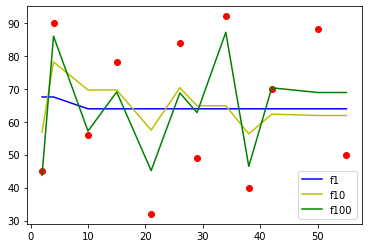

In [ ]:
tmp = np.array([temparature]).reshape(-1)
f_1 = xgboost(tmp, 2)
f_10 = xgboost(tmp, 10)
f_100 = xgboost(tmp, 100)

plt.plot(year, f_1, 'b')
plt.plot(year, f_10,'y')
plt.plot(year, f_100, 'g')
plt.legend(['f1','f10','f100'])
plt.scatter(year, tmp, c='r')
plt.show()

#### Built-in library

For more details, you can refer to https://xgboost.readthedocs.io/en/latest/build.html


In [ ]:
# Install xgboost library
!pip install xgboost

In [ ]:
# Data Process

# Loading 
from sklearn import datasets
import xgboost as xgb

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Spliting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# Data transform into DMatrix format
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [ ]:
# Defining a XGboost model
param = {
    'eta': 0.5, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 3,
    'eval_metric':'mlogloss'} 

steps = 5  # The number of training iterations

In [ ]:
# Train the model
model = xgb.train(param, D_train, steps)

# Model Evaluation
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))